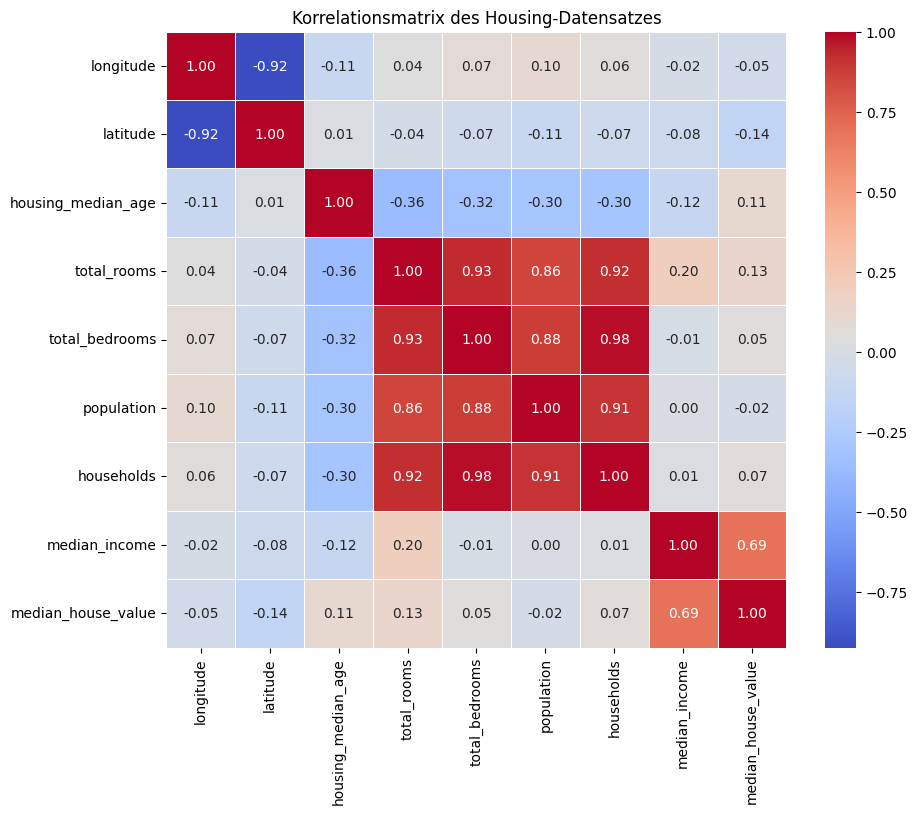

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

housing = pd.read_csv("housing.csv")
corr = housing.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korrelationsmatrix des Housing-Datensatzes')
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

housing = pd.read_csv("housing.csv")
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_numeric = X.select_dtypes(include=[np.number])

def evaluate(drop_cols):
    cols = [c for c in X_numeric.columns if c not in drop_cols]
    X_sub = X_numeric[cols]
    X_train_num, X_test_num, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=42)
    imputer = SimpleImputer(strategy="mean")
    X_train_imp = imputer.fit_transform(X_train_num)
    X_test_imp = imputer.transform(X_test_num)

    # SelectKBest -> LinearRegression
    k = min(5, X_train_imp.shape[1])
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train_imp, y_train)
    sel_mask = selector.get_support()
    sel_features = list(X_train_num.columns[sel_mask])
    X_train_kbest = X_train_imp[:, sel_mask]
    X_test_kbest = X_test_imp[:, sel_mask]
    model_k = LinearRegression().fit(X_train_kbest, y_train)
    y_k_pred = model_k.predict(X_test_kbest)
    rmse_k = np.sqrt(mean_squared_error(y_test, y_k_pred))

    # RandomForest -> Feature importances -> top-k -> LinearRegression
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train_imp, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train_num.columns).sort_values(ascending=False)
    top_features = list(importances.head(k).index)
    top_mask = [col in top_features for col in X_train_num.columns]
    X_train_top = X_train_imp[:, top_mask]
    X_test_top = X_test_imp[:, top_mask]
    model_r = LinearRegression().fit(X_train_top, y_train)
    y_r_pred = model_r.predict(X_test_top)
    rmse_r = np.sqrt(mean_squared_error(y_test, y_r_pred))

    return {
        "dropped": drop_cols,
        "sel_features": sel_features,
        "top_features": top_features,
        "rmse_kbest": rmse_k,
        "rmse_rf": rmse_r
    }

variants = [
    [],                      # baseline
    ["households"],          # drop households
    ["population"],          # drop population
    ["total_rooms"],         # drop total_rooms
    ["latitude"],            # drop latitude
    ["longitude"]            # drop longitude
]

results = [evaluate(v) for v in variants]
df = pd.DataFrame([{
    "dropped": ",".join(r["dropped"]) or "none",
    "sel_features": ", ".join(r["sel_features"]),
    "top_features": ", ".join(r["top_features"]),
    "rmse_SelectKBest_LR": r["rmse_kbest"],
    "rmse_RFtop_LR": r["rmse_rf"]
} for r in results])

print(df.to_string(index=False))

    dropped                                                               sel_features                                                             top_features  rmse_SelectKBest_LR  rmse_RFtop_LR
       none       latitude, housing_median_age, total_rooms, households, median_income       median_income, longitude, latitude, housing_median_age, population         78633.208097   74088.438650
 households   latitude, housing_median_age, total_rooms, total_bedrooms, median_income       median_income, longitude, latitude, housing_median_age, population         79245.105771   74088.438650
 population       latitude, housing_median_age, total_rooms, households, median_income      median_income, longitude, latitude, housing_median_age, total_rooms         78633.208097   73793.096814
total_rooms    latitude, housing_median_age, total_bedrooms, households, median_income       median_income, longitude, latitude, housing_median_age, population         79813.828675   74088.438650
   latitude housing_

CV RMSE (5-fold): mean=69236.33, std=8622.83
Test RMSE: 49499.52


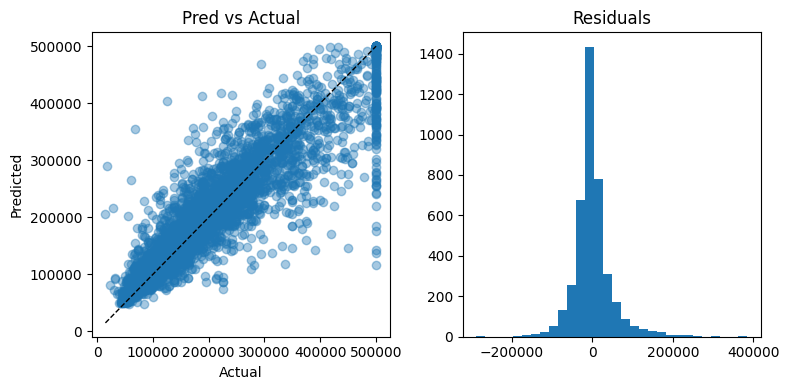

Top 10 Feature Importances:
 median_income               0.481185
ocean_proximity_INLAND      0.138438
population_per_household    0.120916
longitude                   0.057680
latitude                    0.056493
housing_median_age          0.044269
rooms_per_household         0.025963
bedrooms_per_room           0.024478
total_rooms                 0.012750
total_bedrooms              0.011962


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Lade Daten und erstelle einfache Feature-Engineering-Features
housing = pd.read_csv("housing.csv")
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# Ziel / Merkmale
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Spaltenlisten
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

# Preprocessing-Pipes
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Modell-Pipeline
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Cross-Validation (5-fold) RMSE
scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rmse_cv = np.sqrt(-scores)
print("CV RMSE (5-fold): mean={:.2f}, std={:.2f}".format(rmse_cv.mean(), rmse_cv.std()))

# Train/Test-Fit für finalen Test RMSE und Residuenanalyse
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", round(rmse_test, 2))

# Kurze Residual-Check (optional)
import matplotlib.pyplot as plt
res = y_test - y_pred
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--',linewidth=1)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual")
plt.subplot(1,2,2)
plt.hist(res, bins=30)
plt.title("Residuals")
plt.tight_layout()
plt.show()

# (Optional) Feature-Importances anzeigen — falls sklearn-Version get_feature_names_out unterstützt
try:
    num_names = numeric_cols
    cat_names = pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
    feature_names = num_names + cat_names
    importances = pipeline.named_steps['model'].feature_importances_
    imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("Top 10 Feature Importances:\n", imp_series.head(10).to_string())
except Exception:
    pass

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Lade Daten + simples Feature-Engineering (falls noch nicht vorhanden)
housing = pd.read_csv("housing.csv")
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Spaltenlisten
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

# Preprocessor (Num + Cat)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Modelle + Grid (verwende 'model__' Prefix für Pipeline-Param)
models_and_grids = {
    "LinearRegression": (
        LinearRegression(),
        {"model__fit_intercept": [True, False]}
    ),
    "Ridge": (
        Ridge(),
        {"model__alpha": [0.1, 1.0, 10.0]}
    ),
    "SVR": (
        SVR(),
        {"model__C": [1, 10], "model__kernel": ["rbf", "linear"], "model__gamma": ["scale"]}
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {"model__max_depth": [5, 10, None], "model__min_samples_leaf": [1, 5]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {"model__n_estimators": [100, 200], "model__max_depth": [10, None]}
    ),
    "XGBoost": (
        XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
        {"model__n_estimators": [100, 200], "model__max_depth": [3, 6], "model__learning_rate": [0.05, 0.1]}
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42, n_jobs=-1),
        {"model__n_estimators": [100, 200], "model__max_depth": [-1, 10], "model__learning_rate": [0.05, 0.1]}
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=42),
        {"model__iterations": [100, 200], "model__depth": [4, 6], "model__learning_rate": [0.05, 0.1]}
    )
}

# Hold-out für finalen Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
for name, (estimator, grid) in models_and_grids.items():
    pipe = Pipeline([("preproc", preprocessor), ("model", estimator)])
    gs = GridSearchCV(pipe, param_grid=grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    # CV-RMSE (aus best_score_)
    cv_rmse = np.sqrt(-gs.best_score_)
    best_params = gs.best_params_
    # Test-RMSE auf Hold-out
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({
        "model": name,
        "cv_rmse": cv_rmse,
        "test_rmse": test_rmse,
        "best_params": best_params
    })

res_df = pd.DataFrame(results).sort_values("cv_rmse")
print(res_df.to_string(index=False))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Start training from score 207163.052006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 15
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Lade Daten
housing = pd.read_csv("housing.csv")

# === ERWEITERTE FEATURE ENGINEERING ===

# 1. Basis-Features (wie zuvor)
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# 2. Polynomiale Features für wichtige Variablen
housing['median_income_squared'] = housing['median_income'] ** 2
housing['median_income_cubed'] = housing['median_income'] ** 3

# 3. Interaktionen
housing['income_per_room'] = housing['median_income'] / (housing['total_rooms'] + 1)
housing['income_per_person'] = housing['median_income'] / (housing['population'] + 1)
housing['lat_long'] = housing['latitude'] * housing['longitude']
housing['income_times_age'] = housing['median_income'] * housing['housing_median_age']

# 4. Geografisches Clustering (Locations mit ähnlichen Eigenschaften)
X_geo = housing[['latitude', 'longitude']].copy()
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
housing['geo_cluster'] = kmeans.fit_predict(X_geo)

# 5. Log-Transformationen für schiefe Verteilungen
housing['log_total_rooms'] = np.log1p(housing['total_rooms'])
housing['log_population'] = np.log1p(housing['population'])
housing['log_median_income'] = np.log1p(housing['median_income'])

# 6. Binning von Koordinaten (grobe Regionen)
housing['lat_bin'] = pd.cut(housing['latitude'], bins=10, labels=False)
housing['long_bin'] = pd.cut(housing['longitude'], bins=10, labels=False)

# 7. Distanz zu wirtschaftlichem Zentrum (nähe zu teuren Gegenden)
# Approximation: San Francisco ~ (37.77, -122.41)
sf_lat, sf_long = 37.77, -122.41
housing['distance_to_sf'] = np.sqrt(
    (housing['latitude'] - sf_lat)**2 + 
    (housing['longitude'] - sf_long)**2
)

# Entferne Features mit inf/NaN
housing.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Feature Engineering abgeschlossen!")
print(f"Anzahl Features: {housing.shape[1] - 1} (ohne Target)")
print(f"\nNeue Features:\n{[c for c in housing.columns if c not in ['median_house_value', 'latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']]}")

Feature Engineering abgeschlossen!
Anzahl Features: 25 (ohne Target)

Neue Features:
['rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'median_income_squared', 'median_income_cubed', 'income_per_room', 'income_per_person', 'lat_long', 'income_times_age', 'geo_cluster', 'log_total_rooms', 'log_population', 'log_median_income', 'lat_bin', 'long_bin', 'distance_to_sf']


# Feature Engineering: Systematisches Testen verschiedener Feature-Kombinationen

In diesem Abschnitt testen wir verschiedene Feature-Engineering-Strategien und messen deren Einfluss auf den CV-RMSE:

1. **Baseline**: Nur Original-Features
2. **Ratio-Features**: Verhältnisse zwischen numerischen Features
3. **Polynomiale Features**: Quadrate/Kuben wichtiger Features
4. **Geografische Features**: Clustering, Distanzen, Binning
5. **Log-Transformationen**: Für schiefe Verteilungen
6. **Interaktionen**: Produkte zwischen wichtigen Features
7. **Alle kombiniert**: Beste Kombination aller Strategien

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

# Verwende bereits engineerte Features von oben
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

# Preprocessor
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === GRID SEARCH FÜR TOP-MODELLE ===

results = []

# 1. CatBoost (bester aus vorherigem Run)
print("GridSearch: CatBoost...")
pipe_cb = Pipeline([("preproc", preprocessor), ("model", CatBoostRegressor(silent=True, random_state=42))])
grid_cb = {
    "model__iterations": [300, 500, 700],
    "model__depth": [6, 8, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__l2_leaf_reg": [1, 3, 5],
    "model__subsample": [0.8, 1.0]
}
gs_cb = GridSearchCV(pipe_cb, grid_cb, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=0)
gs_cb.fit(X_train, y_train)
cv_rmse_cb = np.sqrt(-gs_cb.best_score_)
test_rmse_cb = np.sqrt(mean_squared_error(y_test, gs_cb.predict(X_test)))
results.append({"model": "CatBoost", "cv_rmse": cv_rmse_cb, "test_rmse": test_rmse_cb, "best_params": gs_cb.best_params_})
print(f"  CatBoost: cv_rmse={cv_rmse_cb:.2f}, test_rmse={test_rmse_cb:.2f}")

# 2. XGBoost
print("GridSearch: XGBoost...")
pipe_xgb = Pipeline([("preproc", preprocessor), ("model", XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1))])
grid_xgb = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}
gs_xgb = GridSearchCV(pipe_xgb, grid_xgb, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=0)
gs_xgb.fit(X_train, y_train)
cv_rmse_xgb = np.sqrt(-gs_xgb.best_score_)
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, gs_xgb.predict(X_test)))
results.append({"model": "XGBoost", "cv_rmse": cv_rmse_xgb, "test_rmse": test_rmse_xgb, "best_params": gs_xgb.best_params_})
print(f"  XGBoost: cv_rmse={cv_rmse_xgb:.2f}, test_rmse={test_rmse_xgb:.2f}")

# 3. LightGBM
print("GridSearch: LightGBM...")
pipe_lgbm = Pipeline([("preproc", preprocessor), ("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))])
grid_lgbm = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [6, 10, -1],
    "model__learning_rate": [0.05, 0.1],
    "model__num_leaves": [31, 63, 127],
    "model__subsample": [0.8, 1.0]
}
gs_lgbm = GridSearchCV(pipe_lgbm, grid_lgbm, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=0)
gs_lgbm.fit(X_train, y_train)
cv_rmse_lgbm = np.sqrt(-gs_lgbm.best_score_)
test_rmse_lgbm = np.sqrt(mean_squared_error(y_test, gs_lgbm.predict(X_test)))
results.append({"model": "LightGBM", "cv_rmse": cv_rmse_lgbm, "test_rmse": test_rmse_lgbm, "best_params": gs_lgbm.best_params_})
print(f"  LightGBM: cv_rmse={cv_rmse_lgbm:.2f}, test_rmse={test_rmse_lgbm:.2f}")

# 4. RandomForest
print("GridSearch: RandomForest...")
pipe_rf = Pipeline([("preproc", preprocessor), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
grid_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", 0.5]
}
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=0)
gs_rf.fit(X_train, y_train)
cv_rmse_rf = np.sqrt(-gs_rf.best_score_)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, gs_rf.predict(X_test)))
results.append({"model": "RandomForest", "cv_rmse": cv_rmse_rf, "test_rmse": test_rmse_rf, "best_params": gs_rf.best_params_})
print(f"  RandomForest: cv_rmse={cv_rmse_rf:.2f}, test_rmse={test_rmse_rf:.2f}")

# Ergebnisse
res_df = pd.DataFrame(results).sort_values("cv_rmse")
print("\n=== GRID SEARCH RESULTS (mit erweiterten Features) ===")
print(res_df[["model", "cv_rmse", "test_rmse"]].to_string(index=False))

# Speichere beste Modelle für nächsten Schritt
best_models = {
    "CatBoost": gs_cb.best_estimator_,
    "XGBoost": gs_xgb.best_estimator_,
    "LightGBM": gs_lgbm.best_estimator_,
    "RandomForest": gs_rf.best_estimator_
}

GridSearch: CatBoost...
  CatBoost: cv_rmse=43850.72, test_rmse=43004.73
GridSearch: XGBoost...
  XGBoost: cv_rmse=44297.46, test_rmse=43143.84
GridSearch: LightGBM...
  LightGBM: cv_rmse=44342.44, test_rmse=43018.78
GridSearch: RandomForest...
  RandomForest: cv_rmse=48608.44, test_rmse=48263.22

=== GRID SEARCH RESULTS (mit erweiterten Features) ===
       model      cv_rmse    test_rmse
    CatBoost 43850.723681 43004.726793
     XGBoost 44297.462888 43143.835120
    LightGBM 44342.436683 43018.783885
RandomForest 48608.435324 48263.216184


Ermittle Vorhersagen aller Modelle auf dem Trainingsset (via Cross-Validation)...
  CatBoost...
  XGBoost...
  LightGBM...
  RandomForest...

Anzahl harter Trainingsbeobachtungen (>95% Quantil): 826
Das entspricht 5.0% des Trainingssets

Mean abs error Quantile:
count     16512.000000
mean      29275.559048
std       33150.060903
min         527.164216
25%        9426.352714
50%       18420.174939
75%       36298.607305
max      363716.413496
Name: mean_abs_error, dtype: float64


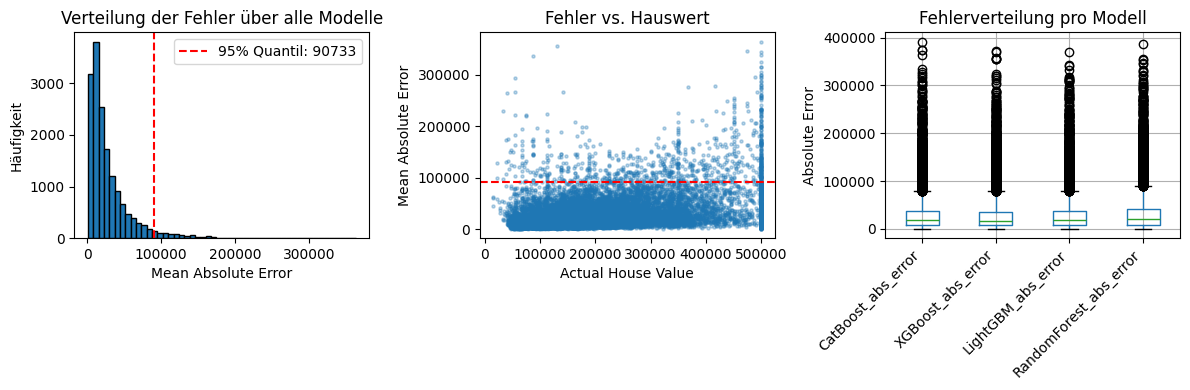


✓ 826 harte Beobachtungen identifiziert


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === IDENTIFIZIERE KONSISTENT FALSCHE TRAININGSBEOBACHTUNGEN ===

print("Ermittle Vorhersagen aller Modelle auf dem Trainingsset (via Cross-Validation)...")

# Sammle CV-Vorhersagen von allen 4 besten Modellen
train_predictions = {}
for model_name, model in best_models.items():
    print(f"  {model_name}...")
    preds = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1)
    train_predictions[model_name] = preds

# Berechne absolute Fehler für jedes Modell
train_errors = pd.DataFrame(index=X_train.index)
for model_name, preds in train_predictions.items():
    train_errors[f"{model_name}_abs_error"] = np.abs(y_train.values - preds)

# Mean absolute error über alle Modelle
train_errors["mean_abs_error"] = train_errors.mean(axis=1)

# Identifiziere Top 5% schlechteste Beobachtungen
threshold_95 = train_errors["mean_abs_error"].quantile(0.95)
hard_indices = train_errors[train_errors["mean_abs_error"] > threshold_95].index.tolist()

print(f"\nAnzahl harter Trainingsbeobachtungen (>95% Quantil): {len(hard_indices)}")
print(f"Das entspricht {100 * len(hard_indices) / len(X_train):.1f}% des Trainingssets")
print(f"\nMean abs error Quantile:")
print(train_errors["mean_abs_error"].describe())

# Visualisierung der Fehlerverteilung
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_errors["mean_abs_error"], bins=50, edgecolor='black')
plt.axvline(threshold_95, color='red', linestyle='--', label=f'95% Quantil: {threshold_95:.0f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Fehler über alle Modelle')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(y_train, train_errors["mean_abs_error"], alpha=0.3, s=5)
plt.xlabel('Actual House Value')
plt.ylabel('Mean Absolute Error')
plt.title('Fehler vs. Hauswert')
plt.axhline(threshold_95, color='red', linestyle='--')

plt.subplot(1, 3, 3)
# Boxplot der Fehler pro Modell
error_cols = [c for c in train_errors.columns if c != "mean_abs_error"]
train_errors[error_cols].boxplot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Absolute Error')
plt.title('Fehlerverteilung pro Modell')
plt.tight_layout()
plt.show()

# Speichere hard_indices für nächsten Schritt
print(f"\n✓ {len(hard_indices)} harte Beobachtungen identifiziert")

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# === TESTE PERFORMANCE NACH OUTLIER-ENTFERNUNG ===

print("=== VERGLEICH: MIT vs. OHNE HARTE BEOBACHTUNGEN ===\n")

# Erstelle gefiltertes Trainingsset (ohne die 5% härtesten Beobachtungen)
X_train_filtered = X_train.drop(index=hard_indices)
y_train_filtered = y_train.drop(index=hard_indices)

print(f"Original Trainingsset: {len(X_train)} Beobachtungen")
print(f"Gefiltertes Trainingsset: {len(X_train_filtered)} Beobachtungen")
print(f"Entfernt: {len(hard_indices)} Beobachtungen ({100*len(hard_indices)/len(X_train):.1f}%)\n")

comparison_results = []

# Teste jedes Modell mit beiden Trainingssets
for model_name, model in best_models.items():
    print(f"Teste {model_name}...")
    
    # Original (mit allen Daten)
    scores_orig = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    cv_rmse_orig = np.sqrt(-scores_orig.mean())
    
    # Gefiltert (ohne harte Beobachtungen)
    scores_filt = cross_val_score(model, X_train_filtered, y_train_filtered, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    cv_rmse_filt = np.sqrt(-scores_filt.mean())
    
    # Train auf gefiltertem Set, teste auf originalem Test-Set
    model_filt = model
    model_filt.fit(X_train_filtered, y_train_filtered)
    y_pred_filt = model_filt.predict(X_test)
    test_rmse_filt = np.sqrt(mean_squared_error(y_test, y_pred_filt))
    
    # Train auf originalem Set, teste auf Test-Set (Referenz)
    model.fit(X_train, y_train)
    y_pred_orig = model.predict(X_test)
    test_rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))
    
    comparison_results.append({
        "model": model_name,
        "cv_rmse_original": cv_rmse_orig,
        "cv_rmse_filtered": cv_rmse_filt,
        "cv_improvement": cv_rmse_orig - cv_rmse_filt,
        "test_rmse_original": test_rmse_orig,
        "test_rmse_filtered": test_rmse_filt,
        "test_improvement": test_rmse_orig - test_rmse_filt
    })

# Ergebnistabelle
comp_df = pd.DataFrame(comparison_results)
comp_df = comp_df.sort_values("cv_rmse_filtered")

print("\n" + "="*80)
print("VERGLEICHSERGEBNISSE")
print("="*80)
print(comp_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print("="*80)

# Beste Verbesserung
best_idx = comp_df["cv_improvement"].idxmax()
best_model_name = comp_df.loc[best_idx, "model"]
best_improvement = comp_df.loc[best_idx, "cv_improvement"]
print(f"\n✓ Beste Verbesserung: {best_model_name} (+{best_improvement:.2f} RMSE durch Outlier-Entfernung)")

# Finale Zusammenfassung
best_overall = comp_df.iloc[0]
print(f"\n🎯 BESTES MODELL: {best_overall['model']}")
print(f"   CV-RMSE (gefiltert): {best_overall['cv_rmse_filtered']:.2f}")
print(f"   Test-RMSE (gefiltert): {best_overall['test_rmse_filtered']:.2f}")
print(f"   Verbesserung vs. Baseline (44400): {44400 - best_overall['cv_rmse_filtered']:.2f}")

=== VERGLEICH: MIT vs. OHNE HARTE BEOBACHTUNGEN ===

Original Trainingsset: 16512 Beobachtungen
Gefiltertes Trainingsset: 15686 Beobachtungen
Entfernt: 826 Beobachtungen (5.0%)

Teste CatBoost...
Teste XGBoost...
Teste LightGBM...
Teste RandomForest...

VERGLEICHSERGEBNISSE
       model  cv_rmse_original  cv_rmse_filtered  cv_improvement  test_rmse_original  test_rmse_filtered  test_improvement
    CatBoost          43850.72          29947.93        13902.80            43004.73            44643.40          -1638.67
     XGBoost          44297.46          30251.63        14045.84            43143.84            45237.43          -2093.60
    LightGBM          44342.44          30384.30        13958.13            43018.78            44985.78          -1967.00
RandomForest          48608.44          35028.89        13579.54            48263.22            49960.32          -1697.11

✓ Beste Verbesserung: XGBoost (+14045.84 RMSE durch Outlier-Entfernung)

🎯 BESTES MODELL: CatBoost
   CV-RMSE

In [15]:
best_model = best_models["CatBoost"]
best_model.fit(X_train_filtered, y_train_filtered)

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
import joblib
joblib.dump(best_model, "best_house_model.pkl")

['best_house_model.pkl']

In [17]:
y_pred_final = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
print(f"Finale Test-RMSE: {final_rmse:.2f}")

Finale Test-RMSE: 44643.40
